In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

## Initial setup

First, we define a few helper functions.

In [2]:
def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

class FCN(nn.Module):
    "Defines a standard fully-connected network in PyTorch"
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

#### Task

The task is to use a PINN to **simulate** the system.

Specifically, our inputs and outputs are:

- Inputs: underlying differential equation and the initial conditions of the system
- Outputs: estimate of the solution, $u(t)$

#### Approach

The PINN is trained to directly approximate the solution to the differential equation, i.e.

$$
u_{\mathrm{PINN}}(t;\theta) \approx u(t)~,
$$

where $\theta$ are the free parameters of the PINN.

#### Loss function

To simulate the system, the PINN is trained with the following loss function:

$$
\mathcal{L}(\theta)= (u_{\mathrm{PINN}}(t=0;\theta) - 1)^2 + \lambda_1 \left(\frac{d\,u_{\mathrm{PINN}}}{dt}(t=0;\theta) - 0\right)^2 + \frac{\lambda_2}{N} \sum^{N}_{i} \left( \left[ m\frac{d^2}{dt^2} + \mu \frac{d}{dt} + k \right] u_{\mathrm{PINN}}(t_{i};\theta)  \right)^2
$$

For this task, we use $\delta=2$, $\omega_0=20$, and try to learn the solution over the domain $t\in [0,1]$.

#### Notes

The first two terms in the loss function represent the **boundary loss**, and tries to ensure that the solution learned by the PINN matches the initial conditions of the system, namely, $u(t=0)=1$ and $u'(t=0)=0$.

The second term in the loss function is called the **physics loss**, and and tries to ensure that the PINN solution obeys the underlying differential equation at a set of training points $\{t_i\}$ sampled over the entire domain.

The hyperparameters, $\lambda_1$ and $\lambda_2$, are used to balence the terms in the loss function, to ensure stability during training.

Autodifferentiation (`torch.autograd`) is used to calculate the gradients of the PINN with respect to its input required to evaluate the loss function. This is very powerful! 

For more details on `torch.autograd`, check out [this](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#a-gentle-introduction-to-torch-autograd) tutorial.

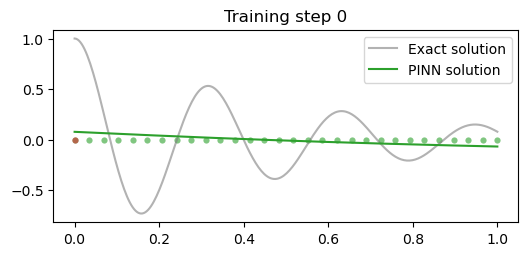

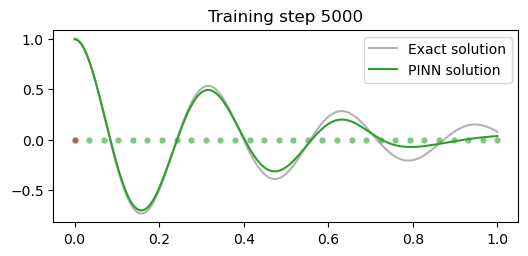

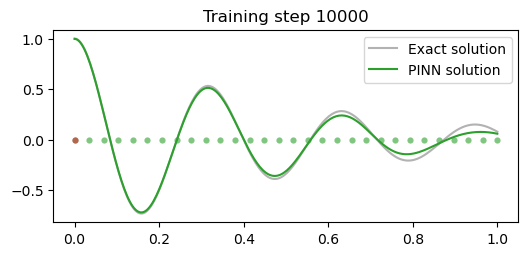

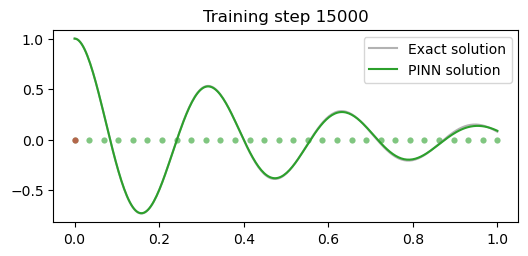

In [3]:
torch.manual_seed(123)

# define a neural network to train
# TODO: write code here
pinn = FCN(1,1,32,3)

# define boundary points, for the boundary loss
# TODO: write code here
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# define training points over the entire domain, for the physics loss
# TODO: write code here
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# train the PINN
d, w0 = 2, 20
mu, k = 2*d, w0**2
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-3)
for i in range(15001):
    optimiser.zero_grad()
    
    # compute each term of the PINN loss function above
    # using the following hyperparameters:
    lambda1, lambda2 = 1e-1, 1e-4
    
    # compute boundary loss
    # TODO: write code here
    u = pinn(t_boundary)
    loss1 = (torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2
    
    # compute physics loss
    # TODO: write code here
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)
    
    # backpropagate joint loss, take optimiser step
    # TODO: write code here
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimiser.step()
    
    # plot the result as training progresses
    if i % 5000 == 0: 
        #print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0], 
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0], 
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()